In [777]:
from pywt import wavedec
from pywt import waverec
import numpy as np
import json
import h5py
import gzip
import matplotlib.pyplot as plt
import os.path

In [778]:
def get_signal(filename):
    with open(filename, 'r') as f:
        return json.load(f)[0]

In [1136]:
mywname = 'db6' # wavelet family
    
wlevel = 4; #decomposition level
    
icase = 'a' # approximation method (a or b)
    
PRD0 = 0.42 # use if icase = a, e.g. 0.4217
    
deL = 25 #quantization parameter (e.g. 32 for a and 39 for b)

In [840]:
def mydwt(signal, wlevel, mywname):
    
    dwt = wavedec(signal, mywname, level = wlevel)
    fw = np.array([])
    l = np.zeros(len(dwt) + 1)
    
    for i in range(len(dwt)):
        fw = np.append(fw, dwt[i])
        l[i] = (dwt[i].shape[0])
    
    l[-1] = signal.shape[0]
    return fw, l

In [841]:
def SLWC(c, tol):
    
    ic = np.argsort(np.abs(c))
    cs = np.abs(c[ic])
    nerror = np.cumsum(cs * cs)
    nlind = ic[nerror >= tol * tol]
    cs = c[nlind]
    
    return cs, nlind

In [842]:
def gzip_compress(vc, vi, vs, wl):
    
    vc_comp = np.bytes_(vc)
    vi_comp = np.bytes_(vi)
    vs_comp = np.bytes_(vs)
    wl_comp = np.bytes_(wl)
    
    vc_comp = gzip.compress(vc_comp)
    vi_comp = gzip.compress(vi_comp)
    vs_comp = gzip.compress(vs_comp)
    wl_comp = gzip.compress(wl_comp)
    
    return vc_comp, vi_comp, vs_comp, wl_comp

In [843]:
def gzip_recover(vc_comp, vi_comp, vs_comp, wl_comp):
    
    vc_comp = gzip.decompress(vc_comp)
    vi_comp = gzip.decompress(vi_comp)
    vs_comp = gzip.decompress(vs_comp)
    wl_comp = gzip.decompress(wl_comp)
    
    vc = np.frombuffer(vc_comp, dtype = np.int16)
    vi = np.frombuffer(vi_comp, dtype = np.int16)
    vs = np.frombuffer(vs_comp, dtype = np.int8)
    wl = np.frombuffer(wl_comp, dtype = np.int32)
    
    return vc, vi, vs, wl
    

In [844]:
def compress(signal, filename_compress):
    
    fw, wl = mydwt(signal, wlevel, mywname)
    L = fw.size
    
    if icase == 'a':
        tol = PRD0 * np.linalg.norm(signal) / 100
        cs, wind = SLWC(fw, tol)
    else:
        cs = fw
        wind = np.linspace(0, L - 1, L - 1)
    
    # quantization of wavelet coefficients
    csq = np.sign(cs) * np.floor(np.abs(cs) / deL + 0.5)
    I0 = np.where(csq == 0)[0]
    if I0.size != 0: #remove the zeros
        csq = np.delete(csq, I0)
        wind = np.delete(wind, I0)
    
    
    #organization and storage
    
    ioR = np.argsort(wind) #sort the indices
    oR = wind[ioR]
    vc = np.abs(csq[ioR])
    
    #take differences
    
    vi = np.append(oR[0], np.diff(oR))
    vs = (np.sign(csq[ioR]) + 1) / 2 #ecnode the signs as zeros ans ones
    
    #save in with gzip compression
    
    vi = np.array(vi, dtype = np.int16)
    vc = np.array(vc, dtype = np.int16)
    vs = np.array(vs, dtype = np.int8)
    wl = np.array(wl, dtype = np.int32)
    
    vc_comp, vi_comp, vs_comp, wl_comp = gzip_compress(vc, vi, vs, wl)
    compression = {'deL': deL, 'L':L, 'vc': vc_comp, 'vi': vi_comp, 'vs': vs_comp, 'wl': wl_comp}
    np.save(filename_compress, compression)
    
    compress_size = os.path.getsize(filename_compress)
    
    CR = 2 * signal.size / compress_size
    
    return CR, compress_size
    

In [845]:
def recover(filename_compress):
    
    compression = np.load(filename_compress, allow_pickle = True)
    compression = compression.tolist()
    
    L = compression['L']
    deL = compression['deL']
    vi_comp = compression['vi']
    vc_comp = compression['vc']
    vs_comp = compression['vs']
    wl_comp = compression['wl']
    
    vc, vi, vs, wl = gzip_recover(vc_comp, vi_comp, vs_comp, wl_comp)
    
   # count = wlevel + 2
    
   # wl = [np.ceil(L_signal / 2**i) for i in range(count-1)]
   # wl = wl + [wl[-1]]
   # wl.reverse()
   # wl = np.array(wl, dtype = np.int32)
        
    orre = np.cumsum(vi) #recover indices
    
    #recover signs
    
    vsre = 2 * vs - 1
    cwre = np.zeros((L))
    
    #recover non-zero coefficients
    
    cwre[orre] = vsre * vc * deL
    
    cum = np.hstack([0 , np.cumsum(wl)])
    
    cwre = [cwre[cum[i - 1]: cum[i]] for i in range(1, cum.size - 1)]
    
    approximation = waverec(cwre, mywname)

    return approximation

In [899]:
def get_approximation(signal, filename_compress, parameter):
    
    signal = signal // parameter
    CR, compress_size = compress(signal, filename_compress)
    approximation = recover(filename_compress)
    
    if(approximation.size > signal.size):
        approximation = approximation[:-1]
    if(parameter != 1):
        approximation *= parameter
    
    PRD = np.max(np.abs(signal - approximation))
    
    return approximation, CR, PRD, compress_size

In [1325]:
def get_approximation_with_step(signal, parameter, step, sample, filename_compress):
    
    summary_ram = 0
    approx_k = np.zeros((signal.size))
    if not os.path.isdir(filename_compress):
        os.mkdir(filename_compress)
    
    #первый шаг
    file = filename_compress + "/signal_1.npy"
    signal_start = signal[:step + sample]
    app_start, CR,_ ,comp_size = get_approximation(signal_start, file, parameter) 
    app_start = app_start[0: step] # не учитываем sample
    approx_k[0:step] = app_start
    summary_ram += comp_size
    
    #шаги в середине
    
    for i in range(1, signal.size // step):
        file = filename_compress + "/signal_" + str(i + 1) + ".npy"
        signal_k = signal[i*step - sample:(i+1)*step + sample]
        app_k, CR,_, comp_size = get_approximation(signal_k, file, parameter)
        app_k = app_k[sample : step + sample] # не учитываем sample
        approx_k[i*step:(i+1)*step] = app_k
        summary_ram += comp_size
    
    #последний шаг
    
    file = filename_compress + "/signal_" + str(signal.size // step) + ".npy"
    signal_finish = signal[-step - sample:]
    app_finish, CR,_, comp_size = get_approximation(signal_finish, file, parameter) 
    app_finish = app_finish[sample:] # не учитываем sample
    approx_k[-step:] = app_finish
    summary_ram += comp_size
    
    return approx_k, summary_ram

In [1324]:
a.size // (500 * 60) - 1

47

In [1464]:
def print_random_signal(X, X_, offset):
    
    L = X.size
    start = np.array([np.random.randint(0, X[i].size - offset) for i in range(L)])
    end = start + offset
    
    for i in range(len(X)):
        plt.figure(figsize=(15,5))
        plt.axis(ymin = -2000, ymax = 2000)
        plt.plot(X[i][start[i]:end[i]])
        plt.plot(X_[i][start[i]:end[i]])
        plt.legend(['original', 'approximation'])

In [893]:
mywname = 'db6' # wavelet family

In [908]:
CR = np.zeros((38))
PRD = np.zeros((38))

for i in range(38):
    mywname = 'db' + str(i + 1)
    _, CR[i], PRD[i], _ = get_approximation(X[9][20000:50000], 'a.npy', 1)

In [916]:
CR.shape = (38, 1)

In [917]:
PRD.shape = (38 ,1)

In [921]:
res = np.hstack((CR, PRD))

In [924]:
number = np.arange(1, 39)

In [928]:
number.shape = (38, 1)
    

In [929]:
result = np.hstack((number, res))

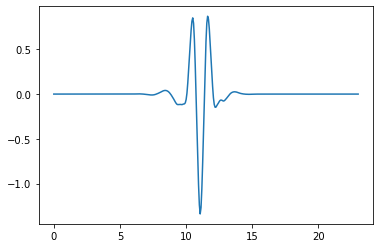

In [1194]:
plt.plot(x, psi)

In [1195]:
mywname = 'coif4'

In [1196]:
app, CR,PRD,_ = get_approximation(X[9][20000:50000], 'a.npy', 1)
print(CR)
print(PRD)

15.919342000530644
12.296373779773631


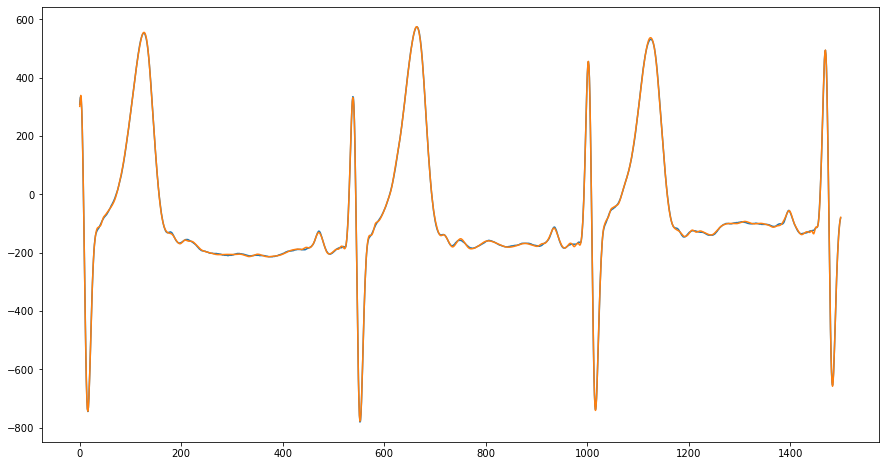

In [1197]:
plt.figure(figsize=(15,8))
plt.plot(X[9][20000:50000][:1500])
plt.plot(app[:1500])

In [1468]:
step = 500 * 60
parameter = 2
sample = 0

X_ = np.empty(len(files), dtype = object)
CR_minute = np.zeros((len(files)))
for i in range(len(files)):
    filename = "ecg-compress/" + files[i]
    X_[i], memory = get_approximation_with_step(X[i], parameter,  step, sample, filename)
    CR_minute[i] = 2 * len(X[i]) / memory

In [1452]:
CR_full = np.zeros((len(files)))
for i in range(len(files)):
    _, CR_full[i],_, _ = get_approximation(X[i], 'a.npy', parameter)

In [1469]:
CR_minute

array([14.27480663, 15.95912319, 20.97872418, 16.68077706, 31.28238713,
       16.48543195, 19.55259395, 16.3500082 , 17.59234553, 16.61060547])

In [1454]:
CR_full

array([23.09572192, 28.60542542, 42.70357221, 31.05199825, 79.67998445,
       32.33292791, 39.867024  , 32.07884176, 33.7252971 , 31.18341891])

In [1467]:
files[0]

'117542_signal.json'

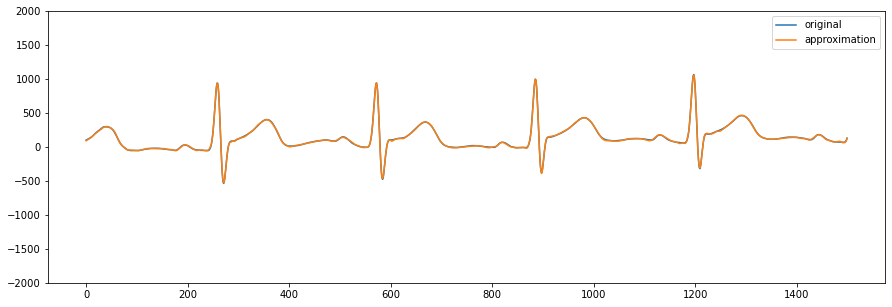

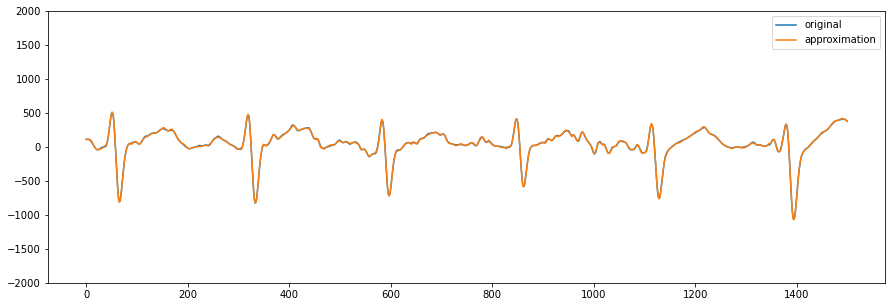

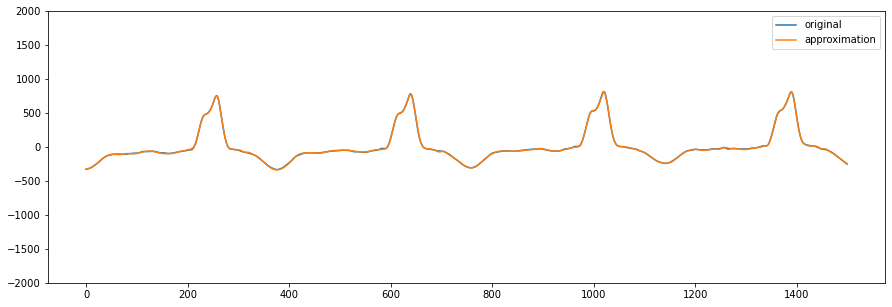

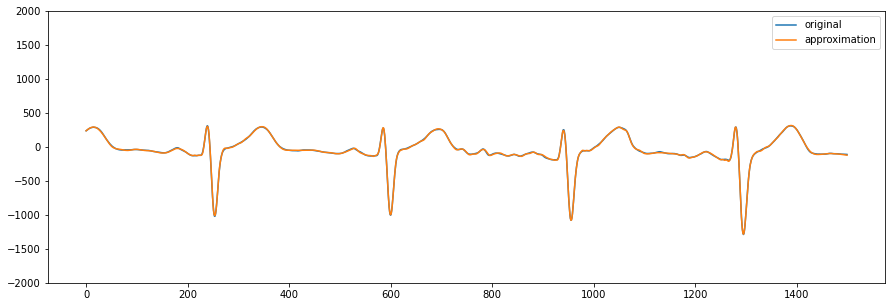

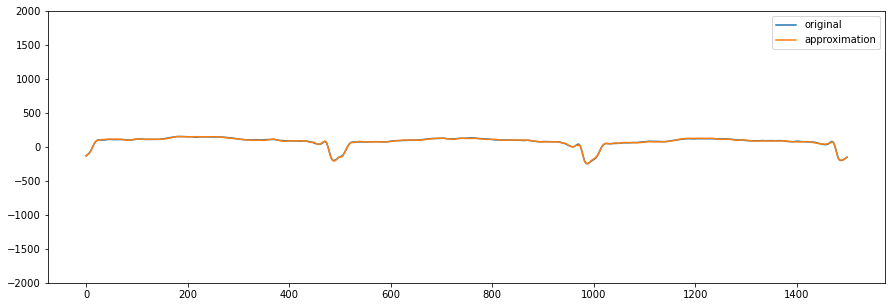

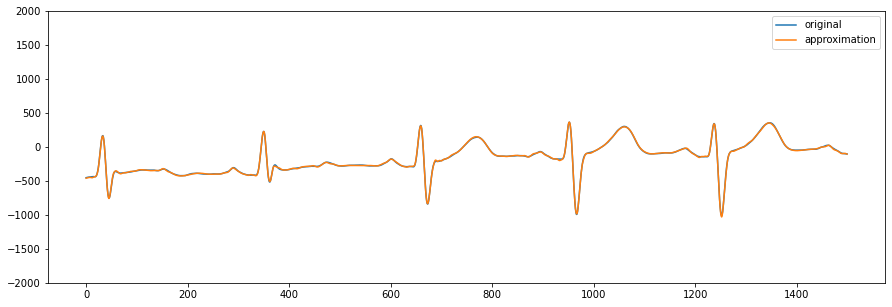

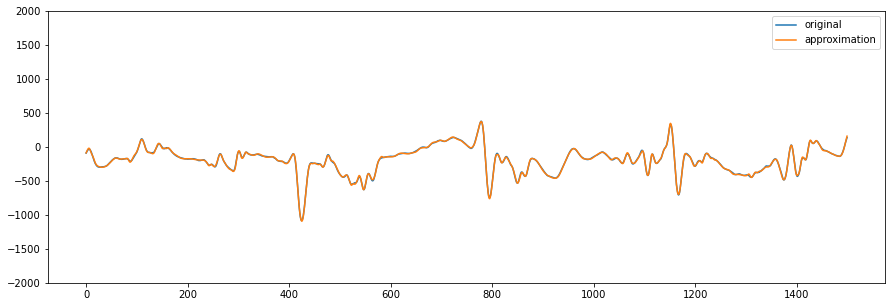

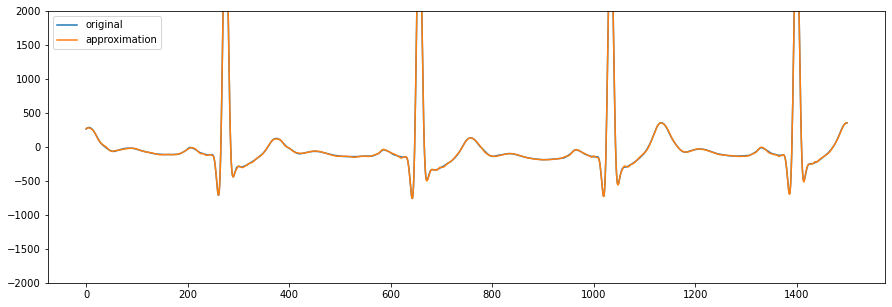

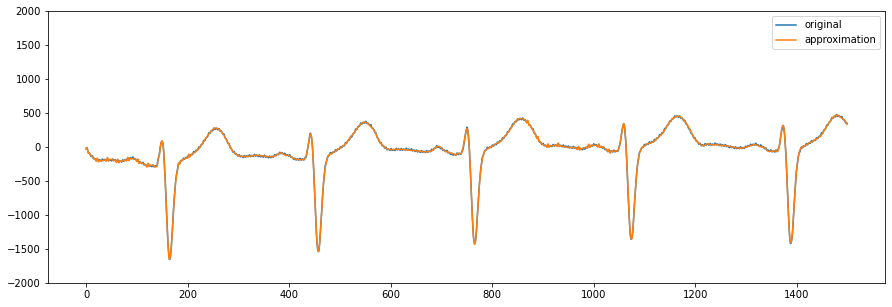

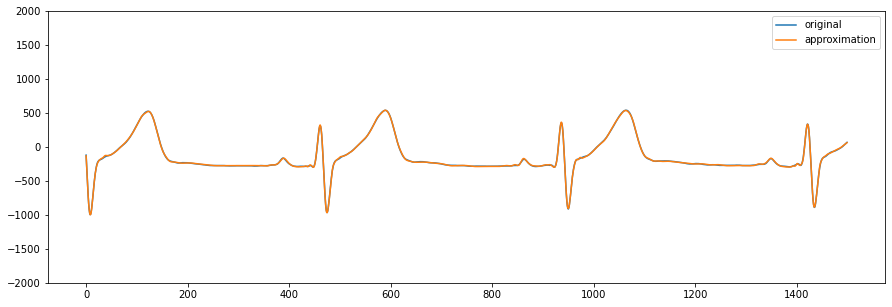

In [1472]:
print_random_signal(X, X_, 500 * 3)

In [1379]:
index = 30000

In [1380]:
start = X_[3][index - 1000:index]

In [1381]:
finish = X[3][index: index + 1000]

In [1382]:
test = np.hstack((start, finish))

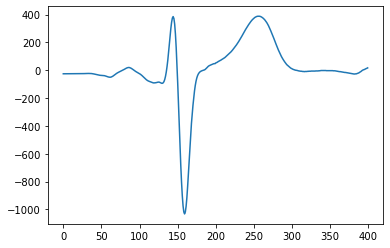

In [1383]:
plt.plot(test[800:1200])

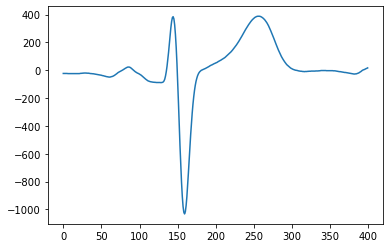

In [1386]:
plt.plot(X[3][index - 1000: index + 1000][800:1200])

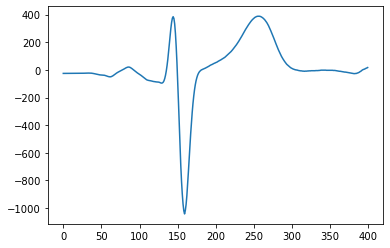

In [1431]:
plt.plot(test[800:1200]) # min

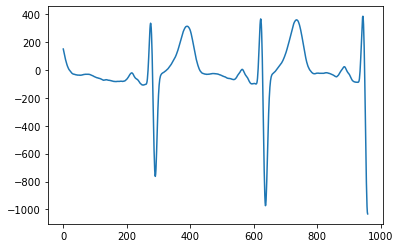

In [1402]:
plt.plot(X[3][index - 1000:index+1000][:960])

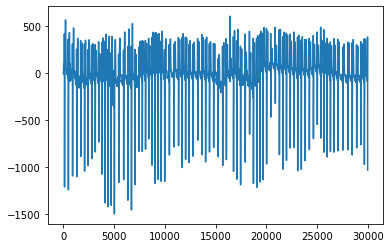

In [1415]:
plt.plot(X[3][:index - 40])

In [1418]:
start,_,_,_ = get_approximation(X[3][:index - 40], 'a.npy', 1)

In [1422]:
finish = X[3][index - 40: index + 1000]

In [1426]:
test = np.hstack((start[index - 1000:index - 40],finish))